In [1]:
!pip install python-dotenv -q

In [2]:
import os
import sys

sys.path.append('..')

import azure.storage.blob as az_blob
from dotenv import load_dotenv
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray as rxr
from shapely.geometry import box
import xarray as xr
import dask_gateway 

from glance_utils import import_prep_glance_bolivia
from glance_utils.azure import build_url, sign_url

load_dotenv()

True

# Baseline land cover classification

In this example we'll show a very minimal way of training a model to classify landcover for a single time-step.

### Get a 2010 median mosaic and our training points

(We've got this from Global Forest Watch, which already has processed mosaics for the red, near infrared, and the two short wave infrared landsat bands)

In [3]:
gdf = import_prep_glance_bolivia()

# the raster covers a slightly smaller area, so let's clip it to make sure all points are inside:
minx, miny, maxx, maxy = -70, -20, -60, -10
bounding_box = box(minx, miny, maxx, maxy)
# this should reduce the number of points from 96k to 80k
gdf = gdf.clip(bounding_box)

In [4]:
# make sure that the data is valid for 2010:
gdf = gdf[(gdf.Start_Year < 2010) & (gdf.End_Year > 2010)]
len(gdf)

78942

In [5]:
url = build_url('tifs/Hansen_GFC-2022-v1.10_first_10S_070W.tif')

In [6]:
# chunk it so it does the lazy array
da = rxr.open_rasterio(sign_url(url, os.environ['SAS_TOKEN']), 
                       chunks=(1, 10000, 10000), ).astype('float32').assign_coords(band=['red','nir', 'swir1','swir2'])

In [7]:
da

<xarray.DataArray (band: 4, y: 40000, x: 40000)>
dask.array<astype, shape=(4, 40000, 40000), dtype=float32, chunksize=(1, 10000, 10000), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) <U5 'red' 'nir' 'swir1' 'swir2'
  * x            (x) float64 -70.0 -70.0 -70.0 -70.0 ... -60.0 -60.0 -60.0 -60.0
  * y            (y) float64 -10.0 -10.0 -10.0 -10.0 ... -20.0 -20.0 -20.0 -20.0
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [8]:
# apply gain factors to get TOA reflectance 
# doc here https://storage.googleapis.com/earthenginepartners-hansen/GFC-2022-v1.10/download.html
da[0] = (da[0] - 1) / 508
da[1] = (da[1] - 1) / 254
da[2] = (da[2] - 1) / 363
da[3] = (da[3] - 1) / 423

### Visualize some points on the map

In [9]:
small_area = da.isel(x=slice(9000,13000), y=slice(9000, 13000)).compute()

In [10]:
minx, miny = small_area.x.min().values, small_area.y.min().values
maxx, maxy = small_area.x.max().values, small_area.y.max().values

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


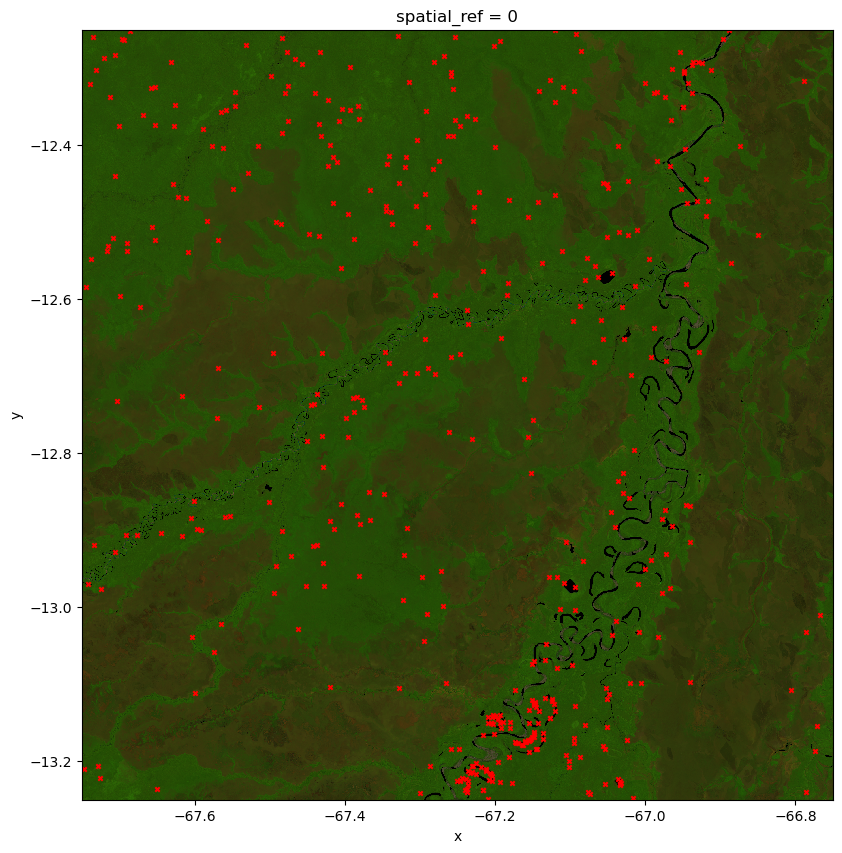

In [11]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
small_area[[2,1,0]].plot.imshow(ax=ax)
gdf.clip(box(minx, miny, maxx, maxy)).plot(ax=ax, color='red', markersize=10, marker='x')
plt.show()

### Let's extract the pixel values at the point locations:

In [12]:
# get the points, making sure that the CRS is the same
points = np.array([(p.x, p.y) for p in gdf.to_crs(da.rio.crs).geometry])
point_id = np.array(gdf['ID'])

x = xr.DataArray(points[:,0], dims=['point_id'], coords={'point_id':point_id ,})
y = xr.DataArray(points[:,1], dims=['point_id'],coords={'point_id':point_id })

In [13]:
extracted_points = da.sel(x=x, y=y, method='nearest')

In [14]:
ep = extracted_points.drop(['x','y','spatial_ref'])

this takes about 20 minutes on this machine, so let's better call the cluster to speed things up a bit:

In [15]:
cluster = dask_gateway.GatewayCluster()  

client = cluster.get_client()
# cluster.scale(8)
cluster.adapt(minimum=2, maximum=100)
print(cluster.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.359d728091774ec396f0f1848dcb935e/status


In [16]:
%%time
ep = ep.compute()

CPU times: user 361 ms, sys: 300 ms, total: 661 ms
Wall time: 1min 36s


In [17]:
ep.shape

(4, 78942)

let's turn it into something more familiar 

In [18]:
df = pd.DataFrame(data=ep.transpose(), index=ep.point_id, 
                      columns=['red', 'nir', 'swir1', 'swir2'])

### Do some feature engineering

Extracting some spectral indices

In [19]:
epsilon = 1e-5
df['ndvi'] = (df['nir'] - df['red']) / (df['nir'] + df['red'] + epsilon) 
df['nbr'] = (df['nir'] - df['swir2']) / (df['nir'] + df['swir2'] + epsilon) 
df['ndmi'] = (df['nir'] - df['swir1']) / (df['nir'] + df['swir1'] + epsilon) 

In [20]:
df['ID'] = ep.point_id

bring in the labels 

In [21]:
df = df.merge(gdf, on='ID')

In [22]:
import seaborn as sns

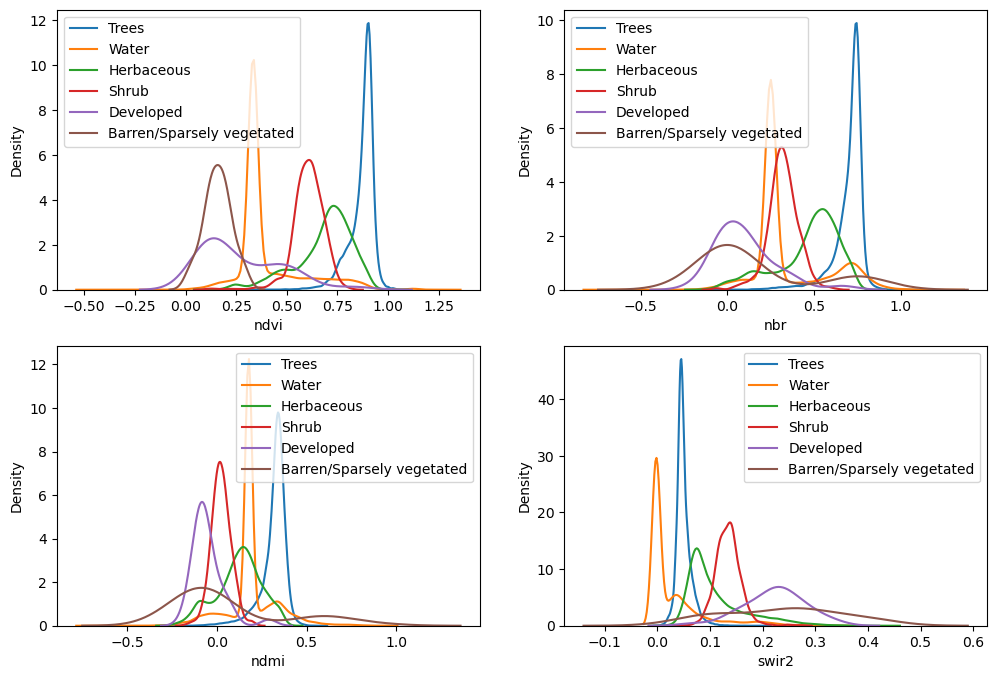

In [23]:
fig, ax = plt.subplots(2,2, figsize=(12,8))
ax = ax.flatten()

for lc_class in df['Glance_Class_ID_level1'].unique():
    
    for n, index in enumerate(['ndvi', 'nbr', 'ndmi', 'swir2']):
        sns.kdeplot(data=df[df.Glance_Class_ID_level1 == lc_class], x=index, 
                label=lc_class, ax=ax[n])

    
for axis in ax:
    axis.legend()

plt.show()

In [24]:
X = df[['red','nir','swir1','swir2','ndvi','nbr', 'ndmi']]
y = df.Glance_Class_ID_level1

### Now split the data and train a baseline classifier

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2024,  test_size=0.2)

In [26]:
model = RandomForestClassifier(n_estimators=150, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=150, n_jobs=-1)

In [27]:
preds = model.predict(X_test)

### And see how it did!

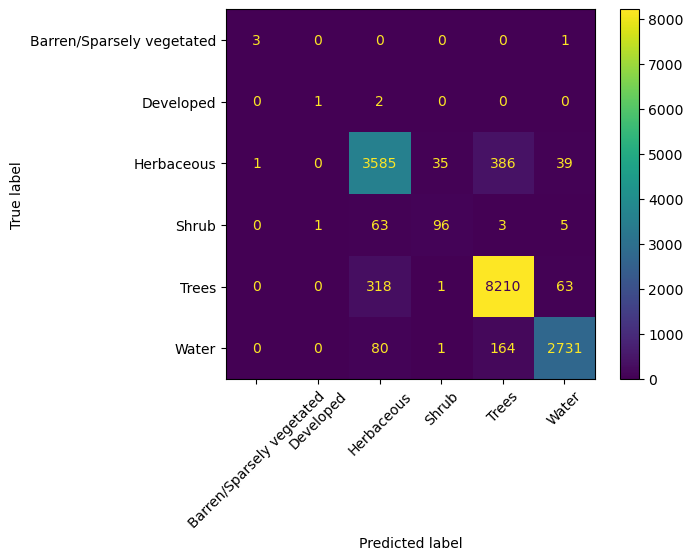

In [28]:
ConfusionMatrixDisplay.from_predictions(y_test, preds, xticks_rotation=45)
plt.show()

In [29]:
print(classification_report(y_test, preds))

                           precision    recall  f1-score   support

Barren/Sparsely vegetated       0.75      0.75      0.75         4
                Developed       0.50      0.33      0.40         3
               Herbaceous       0.89      0.89      0.89      4046
                    Shrub       0.72      0.57      0.64       168
                    Trees       0.94      0.96      0.95      8592
                    Water       0.96      0.92      0.94      2976

                 accuracy                           0.93     15789
                macro avg       0.79      0.74      0.76     15789
             weighted avg       0.93      0.93      0.93     15789



In [30]:
y.value_counts()

Glance_Class_ID_level1
Trees                        42869
Herbaceous                   20209
Water                        15004
Shrub                          795
Developed                       33
Barren/Sparsely vegetated       32
Name: count, dtype: int64

As is to be expected, the classifier does fairly bad in Developed and Sparse land. It also confuses a good deal of Shrub with Herbaceous (which can be quite similar).

A lot of this will be due to the imbalance in the classifier, how could we make the classifier do better for the minority classes?

In [31]:
from sklearn.inspection import permutation_importance

def plot_permutation_importance(clf, X, y, ax):
    result = permutation_importance(clf, X, y, n_repeats=10, random_state=2024)
    perm_sorted_idx = result.importances_mean.argsort()

    ax.boxplot(
        result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X.columns[perm_sorted_idx],
    )
    ax.axvline(x=0, color="k", linestyle="--")
    return ax

CPU times: user 2min 52s, sys: 3.92 s, total: 2min 56s
Wall time: 1min 8s


<Axes: >

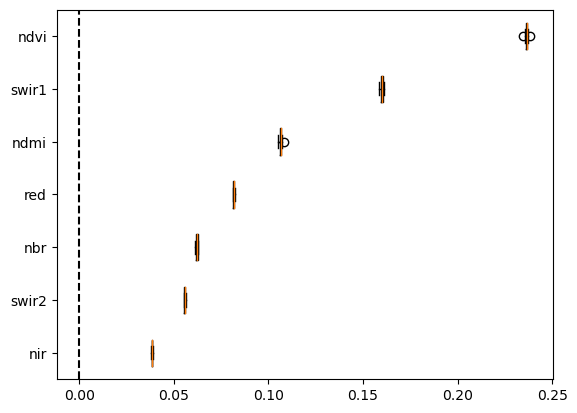

In [32]:
%%time
fig, ax = plt.subplots(1,1)
plot_permutation_importance(model, X, y, ax)